In [44]:
import ast

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import gridspec
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['legend.fontsize'] = 12

In [3]:
pd.set_option('display.max_rows', None)  # display all rows.
pd.set_option('display.float_format', '{:.2f}'.format)  # two decimals.

plt.style.use('grayscale')

%matplotlib inline

In [1]:
experiments = pd.read_csv("experiments/experiments.csv", index_col="experiment")

NameError: name 'pd' is not defined

In [ ]:
exp = pd.DataFrame(index=experiments.index)
exp["w"] = experiments.penalty.apply(lambda p: f"{int(100 * p)}%")

exp["sigma"] = experiments.progress.apply(int)

l2s = {800: "M", 1200: "L", 1600: "XL"}
exp["size"] = experiments.learners.apply(lambda l: l2s[l])

exp["split"] = np.where(experiments.split, "Yes", "No")
exp["qualifications"] = experiments.qualifications

print(exp.to_latex())

In [5]:
def get_all_data(method, modifier='', num_exps=72):
    data = pd.DataFrame()

    for experiment in range(1, num_exps + 1):
        df = pd.read_csv(f"cache/{modifier}{experiment}-{method}.csv")
        df["experiment"] = experiment
        
        data = data.append(df, ignore_index=True)

    return data.set_index(["experiment", "instance"])

In [6]:
heuristic = get_all_data("heuristic")
heuristic.head()

objective  instruction (# learners)  \
experiment instance                                        
1          1           4774.84                       611   
           2           4759.64                       606   
           3           4640.12                       611   
           4           4680.35                       588   
           5           4701.76                       611   

                     self-study (# learners)  activities (#)  
experiment instance                                           
1          1                             189              43  
           2                             194              43  
           3                             189              43  
           4                             212              43  
           5                             189              43

In [7]:
ilp = get_all_data("ilp")
ilp.head()

objective  instruction (# learners)  \
experiment instance                                        
1          1           4777.54                       611   
           2           4765.53                       608   
           3           4644.67                       613   
           4           4690.98                       590   
           5           4709.46                       616   

                     self-study (# learners)  activities (#)  \
experiment instance                                            
1          1                             189              43   
           2                             192              43   
           3                             187              43   
           4                             210              43   
           5                             184              43   

                                            instruction activity sizes  
experiment instance                                                     
1          1         [12, 14, 13, 13, 19, 20, 15, 12, 13, 11, 14, 2...  
           2         [11, 11, 15, 14, 19, 18, 20, 14, 15, 14, 13, 1...  
           3         [16, 11, 16, 13, 19, 11, 18, 13, 12, 15, 19, 1...  
           4         [16, 14, 17, 16, 14, 15, 14, 12, 13, 9, 11, 13...  
           5         [11, 17, 13, 11, 22, 17, 15, 19, 13, 12, 18, 1...

# Objectives

In [8]:
objectives = pd.DataFrame(index=heuristic.index)

objectives["ilp"] = ilp.objective
objectives["heuristic"] = heuristic.objective
objectives["percentage"] = 100 * (ilp.objective - heuristic.objective) / heuristic.objective

grouped = objectives.groupby("experiment")

In [9]:
# Sanity check: the heuristic can never perform better than the optimal
# values for each problem instance.
assert len(objectives[objectives.ilp < objectives.heuristic]) == 0

In [10]:
print("Average difference (%) between heuristic and ILP objectives:")
100 * (ilp.objective.sum() - heuristic.objective.sum()) / heuristic.objective.sum()

Average difference (%) between heuristic and ILP objectives:


0.6487416879025373

Text(0, 0.5, 'Experiments (#)')

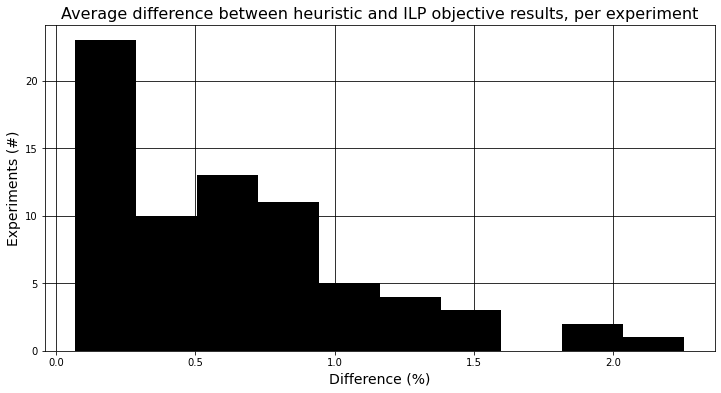

In [11]:
grouped.percentage.mean().hist(figsize=(12, 6))
plt.title("Average difference between heuristic and ILP objective results, per experiment")
plt.xlabel("Difference (%)")
plt.ylabel("Experiments (#)")

In [2]:
grouped.percentage.max().hist(figsize=(12, 6))
plt.title("Max. diff between heuristic and ILP objectives of any instance in the experiment, per experiment")
plt.xlabel("Difference (%)")
plt.ylabel("Experiments (#)")

NameError: name 'grouped' is not defined

In [13]:
# This is used for the results table in the paper.
aggregates = grouped.aggregate({"ilp": "mean", "heuristic": "mean", "percentage": ["mean", "min", "max"]})
formatters = {("percentage", agg): "{:.2f}%".format for agg in ["mean", "min", "max"]}

# For in the appendix
print(aggregates.to_latex(longtable=True, label="tab:heuristic_performance", formatters=formatters))

\begin{longtable}{lrrrrr}
\label{tab:heuristic_performance}\\
\toprule
{} &     ilp & heuristic & \multicolumn{3}{l}{percentage} \\
{} &    mean &      mean &       mean &   min &   max \\
experiment &         &           &            &       &       \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
1          & 4726.15 &   4719.89 &      0.13\% & 0.00\% & 0.32\% \\
2          & 4717.15 &   4711.47 &      0.12\% & 0.01\% & 0.27\% \\
3          & 4720.07 &   4714.77 &      0.11\% & 0.00\% & 0.29\% \\
4          & 4845.05 &   4835.82 &      0.19\% & 0.05\% & 0.32\% \\
5          & 4853.04 &   4843.85 &      0.19\% & 0.07\% & 0.36\% \\
6          & 4800.44 &   4788.20 &      0.26\% & 0.09\% & 0.48\% \\
7          & 9773.15 &   9765.84 &      0.07\% & 0.01\% & 0.18\% \\
8          & 9751.89 &   9745.08 &      0.07\% & 0.01\% & 0.19\% \\
9          & 9751.20 &   9742.71 &      0.09\% & 0.01\% & 0.19\% \\
10         & 97

In [14]:
pct = objectives.reset_index()
pct = pct.join(experiments, on='experiment')
pct.head()

experiment  instance     ilp  heuristic  percentage  penalty  progress  \
0           1         1 4777.54    4774.84        0.06        1         0   
1           1         2 4765.53    4759.64        0.12        1         0   
2           1         3 4644.67    4640.12        0.10        1         0   
3           1         4 4690.98    4680.35        0.23        1         0   
4           1         5 4709.46    4701.76        0.16        1         0   

   learners  instruction_classrooms  instruction_size  self_study_classrooms  \
0       800                      40                32                      3   
1       800                      40                32                      3   
2       800                      40                32                      3   
3       800                      40                32                      3   
4       800                      40                32                      3   

   self_study_size  num_teachers  first_degree  second_degree  third_degree  
0               80            80          1.00           0.00          0.00  
1               80            80          1.00           0.00          0.00  
2               80            80          1.00           0.00          0.00  
3               80            80          1.00           0.00          0.00  
4               80            80          1.00           0.00          0.00

In [15]:
PROPS = {
    'boxprops':{'facecolor':'black', 'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

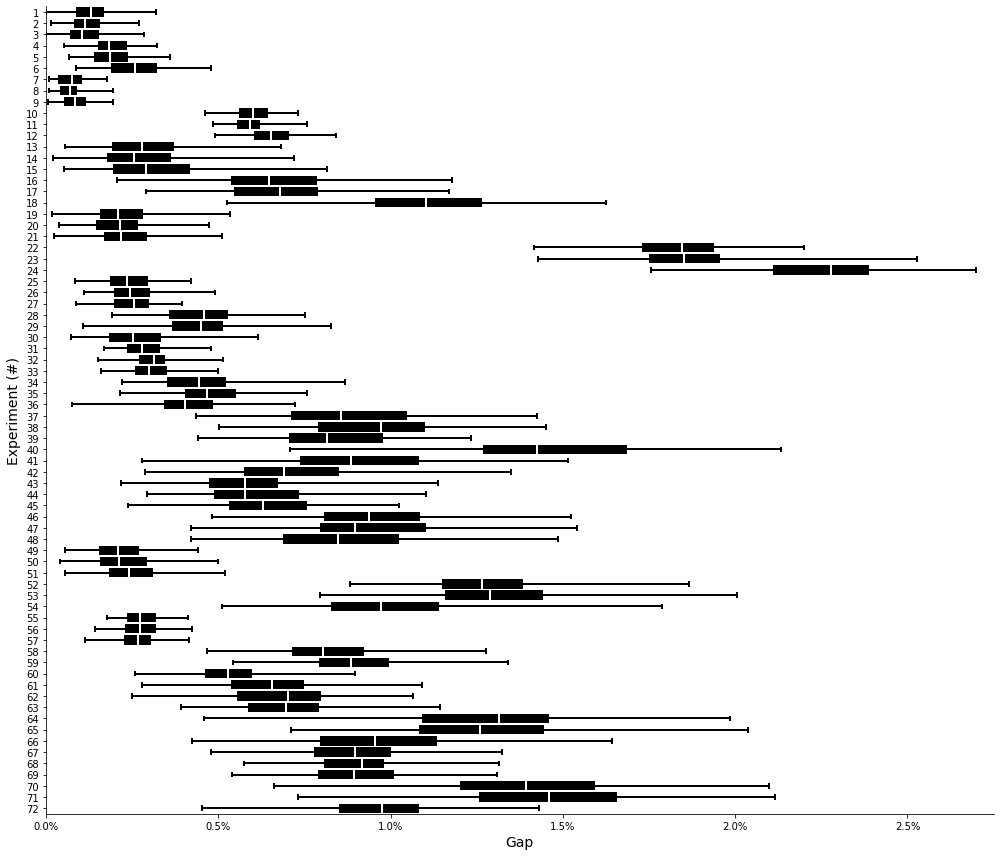

In [16]:
_, ax = plt.subplots(figsize=(14, 12))
ax.invert_yaxis()

sns.boxplot(orient='h', ax=ax, data=pct, x='percentage', y='experiment', whis=(0, 100), width=.65, **PROPS)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
ax.set_xlim([0, 2.75])

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

ax.set_ylabel("Experiment (#)", labelpad=5)
ax.set_xlabel("Gap")

plt.tight_layout()
plt.savefig("out/gaps.pdf", bbox_inches='tight');

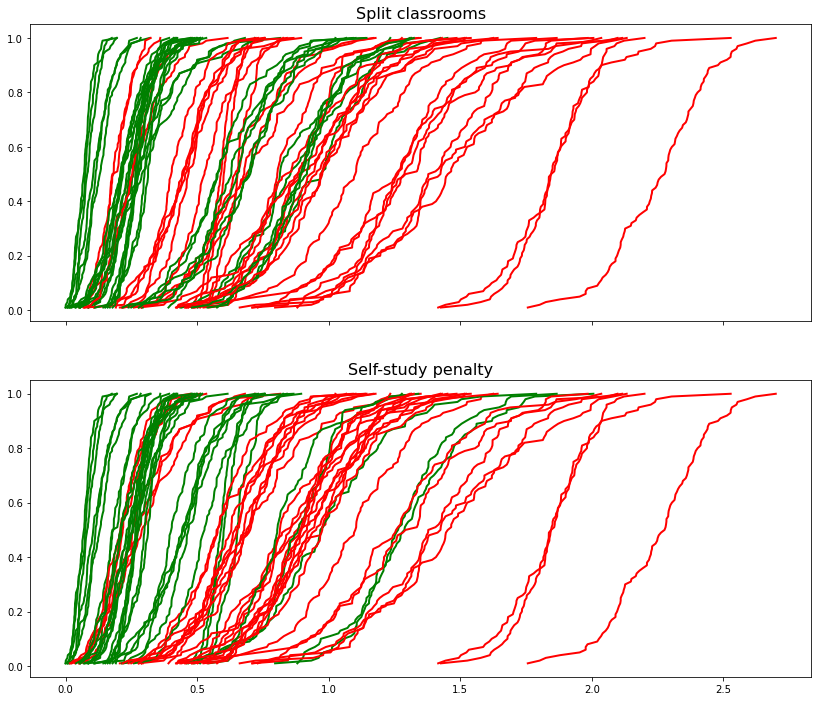

In [17]:
_, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

for experiment in pct.experiment.unique():
    dt = pct[pct.experiment == experiment]
    row = dt.iloc[0]
    
    ecdf = ECDF(dt.percentage)
    axes[0].plot(ecdf.x, ecdf.y, color='g' if row.instruction_size==32 else 'r');
    axes[0].set_title("Split classrooms")

for experiment in pct.experiment.unique():
    dt = pct[pct.experiment == experiment]
    row = dt.iloc[0]
    
    ecdf = ECDF(dt.percentage)
    axes[1].plot(ecdf.x, ecdf.y, color='g' if row.penalty==1 else 'r');
    axes[1].set_title("Self-study penalty")

# Experimental results

In [25]:
width = 0.85
ylim = [-.55, 1.45]
repeat = 2

In [26]:
data = ilp.join(experiments)
data["self-study (% learners)"] = data["self-study (# learners)"] 
data.loc[data.learners == 800, "self-study (% learners)"] /= 8
data.loc[data.learners == 1600, "self-study (% learners)"] /= 16

data.head()

objective  instruction (# learners)  \
experiment instance                                        
1          1           4777.54                       611   
           2           4765.53                       608   
           3           4644.67                       613   
           4           4690.98                       590   
           5           4709.46                       616   

                     self-study (# learners)  activities (#)  \
experiment instance                                            
1          1                             189              43   
           2                             192              43   
           3                             187              43   
           4                             210              43   
           5                             184              43   

                                            instruction activity sizes  \
experiment instance                                                      
1          1         [12, 14, 13, 13, 19, 20, 15, 12, 13, 11, 14, 2...   
           2         [11, 11, 15, 14, 19, 18, 20, 14, 15, 14, 13, 1...   
           3         [16, 11, 16, 13, 19, 11, 18, 13, 12, 15, 19, 1...   
           4         [16, 14, 17, 16, 14, 15, 14, 12, 13, 9, 11, 13...   
           5         [11, 17, 13, 11, 22, 17, 15, 19, 13, 12, 18, 1...   

                     penalty  progress  learners  instruction_classrooms  \
experiment instance                                                        
1          1               1         0       800                      40   
           2               1         0       800                      40   
           3               1         0       800                      40   
           4               1         0       800                      40   
           5               1         0       800                      40   

                     instruction_size  self_study_classrooms  self_study_size  \
experiment instance                                                             
1          1                       32                      3               80   
           2                       32                      3               80   
           3                       32                      3               80   
           4                       32                      3               80   
           5                       32                      3               80   

                     num_teachers  first_degree  second_degree  third_degree  \
experiment instance                                                            
1          1                   80          1.00           0.00          0.00   
           2                   80          1.00           0.00          0.00   
           3                   80          1.00           0.00          0.00   
           4                   80          1.00           0.00          0.00   
           5                   80          1.00           0.00          0.00   

                     self-study (% learners)  
experiment instance                           
1          1                           23.62  
           2                           24.00  
           3                           23.38  
           4                           26.25  
           5                           23.00

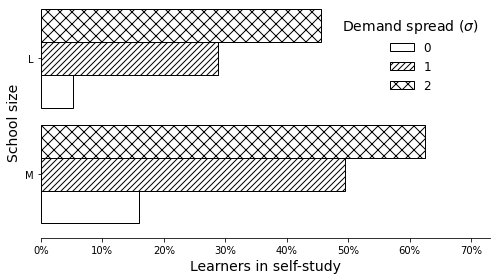

In [28]:
grouped = data.groupby(["learners", "progress"])
ax = grouped["self-study (% learners)"].mean().unstack(1).plot.barh(yticks=[0, 1, 2],
                                                                    figsize=(7, 4), 
                                                                    width=width,
                                                                    edgecolor='black',
                                                                    facecolor='white')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax.set_xlabel("Learners in self-study")
ax.set_ylabel("School size")
ax.set_yticklabels(["M", "L"])

for spine in ['right', 'left', 'top']:
    ax.spines[spine].set_visible(False)

for bar, hatch in zip(ax.patches, ['', '', '//', '//', 'x', 'x']):
    bar.set_hatch(hatch * repeat)
    
ax.legend(title="Demand spread ($\\sigma$)", frameon=False)
ax.set_ylim(ylim)
ax.set_xlim([0, 73])

plt.tight_layout()
plt.savefig("out/progress.pdf", bbox_inches='tight');

In [29]:
print(grouped["self-study (% learners)"].mean())
print(grouped["self-study (# learners)"].mean())

learners  progress
800       0          15.95
          1          49.48
          2          62.50
1600      0           5.30
          1          28.90
          2          45.50
Name: self-study (% learners), dtype: float64
learners  progress
800       0          127.63
          1          395.81
          2          500.02
1600      0           84.76
          1          462.38
          2          728.04
Name: self-study (# learners), dtype: float64


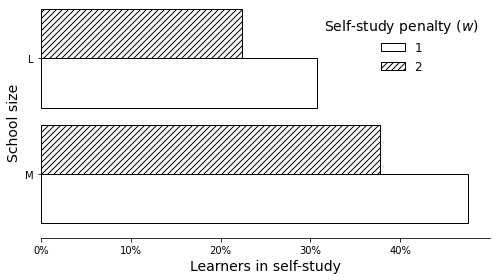

In [30]:
grouped = data.groupby(["learners", "penalty"])
ax = grouped["self-study (% learners)"].mean().unstack(1).plot.barh(figsize=(7, 4), 
                                                                    width=width,
                                                                    edgecolor='black',
                                                                    facecolor='white')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax.set_xlabel("Learners in self-study")
ax.set_ylabel("School size")
ax.set_yticklabels(["M", "L"])

for spine in ['right', 'left', 'top']:
    ax.spines[spine].set_visible(False)

for bar, hatch in zip(ax.patches, ['', '', r'//', r'//']):
    bar.set_hatch(hatch * repeat)

ax.legend(title="Self-study penalty ($w$)", frameon=False)
ax.set_ylim(ylim)

plt.tight_layout()
plt.savefig("out/penalty.pdf", bbox_inches='tight');

In [31]:
print(grouped["self-study (% learners)"].mean())
print(grouped["self-study (# learners)"].mean())

learners  penalty
800       1         47.55
          2         37.73
1600      1         30.76
          2         22.37
Name: self-study (% learners), dtype: float64
learners  penalty
800       1         380.43
          2         301.82
1600      1         492.20
          2         357.92
Name: self-study (# learners), dtype: float64


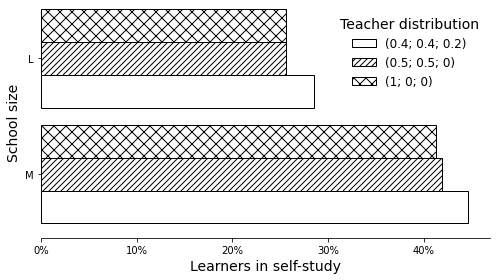

In [32]:
grouped = data.groupby(["learners", "first_degree"])
ax = grouped["self-study (% learners)"].mean().unstack(1).plot.barh(figsize=(7, 4),
                                                                    width=width,
                                                                    edgecolor='black',
                                                                    facecolor='white')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax.set_xlabel("Learners in self-study")
ax.set_ylabel("School size")
ax.set_yticklabels(["M", "L"])

for spine in ['right', 'left', 'top']:
    ax.spines[spine].set_visible(False)

    
for bar, hatch in zip(ax.patches, ['', '', '//', '//', 'x', 'x']):
    bar.set_hatch(hatch * repeat)

ax.legend(["(0.4; 0.4; 0.2)", "(0.5; 0.5; 0)", "(1; 0; 0)"], title="Teacher distribution", frameon=False)
ax.set_ylim(ylim)

plt.tight_layout()
plt.savefig("out/teacher_distribution.pdf", bbox_inches='tight');

In [33]:
print(grouped["self-study (% learners)"].mean())
print(grouped["self-study (# learners)"].mean())

learners  first_degree
800       0.40           44.65
          0.50           41.95
          1.00           41.32
1600      0.40           28.50
          0.50           25.64
          1.00           25.56
Name: self-study (% learners), dtype: float64
learners  first_degree
800       0.40           357.18
          0.50           335.57
          1.00           330.58
1600      0.40           455.99
          0.50           410.24
          1.00           408.96
Name: self-study (# learners), dtype: float64


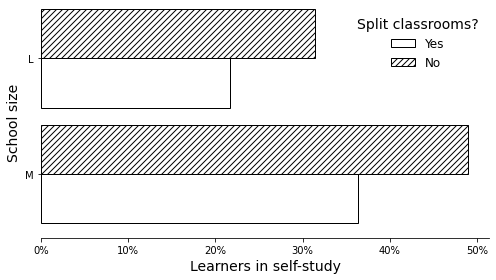

In [34]:
grouped = data.groupby(["learners", "instruction_size"])
ax = grouped["self-study (% learners)"].mean().unstack(1).plot.barh(figsize=(7, 4),
                                                                    width=width,
                                                                    edgecolor='black',
                                                                    facecolor='white')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax.set_xlabel("Learners in self-study")
ax.set_ylabel("School size")
ax.set_yticklabels(["M", "L"])

for spine in ['right', 'left', 'top']:
    ax.spines[spine].set_visible(False)
    
for bar, hatch in zip(ax.patches, ['', '', '//', '//']):
    bar.set_hatch(hatch * repeat)

ax.legend(["Yes", "No"], title="Split classrooms?", frameon=False)
ax.set_ylim(ylim)

plt.tight_layout()
plt.savefig("out/split_classroom.pdf", bbox_inches='tight');

In [35]:
print(grouped["self-study (% learners)"].mean())
print(grouped["self-study (# learners)"].mean())

learners  instruction_size
800       16                 36.34
          32                 48.94
1600      16                 21.67
          32                 31.46
Name: self-study (% learners), dtype: float64
learners  instruction_size
800       16                 290.74
          32                 391.52
1600      16                 346.79
          32                 503.33
Name: self-study (# learners), dtype: float64


## Activity sizes by demand spread

In [36]:
data["intr_list"] = data["instruction activity sizes"].apply(ast.literal_eval)

0 0.7044399532636498
1 0.12809134123593469
2 0.04091047864581565


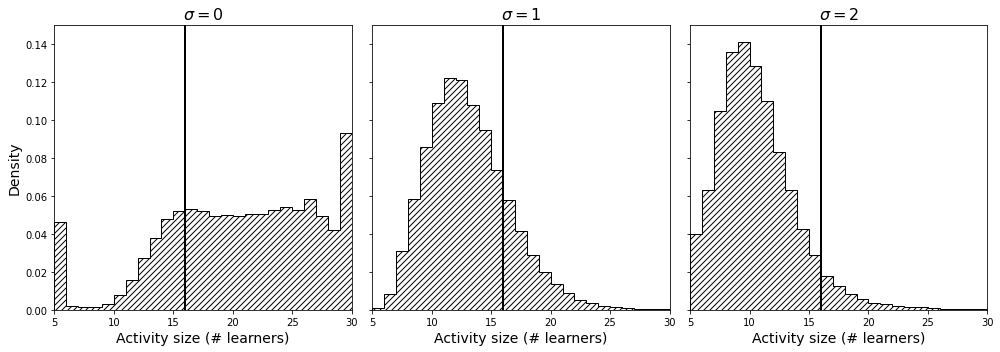

In [37]:
_, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

for ax, sig in zip(axes, [0, 1, 2]):
    items = sum(data[(data.instruction_size == 32) & (data.progress == sig)]["intr_list"], [])

    ax.set_ylim([0, 0.15])
    ax.set_xlim([5, 30])
    hist = ax.hist(items, 25, density=True, histtype='step', linewidth=1, facecolor='white', 
                   hatch='////', edgecolor='black',fill=True)
    
    print(sig, 1 - sum(hist[0][:12]))
    
    ax.vlines(16, 0, 1, linewidth=2, zorder=10)
    
    if ax is axes[0]:
        ax.set_ylabel("Density")
    
    ax.set_title(f"$\\sigma = {sig}$")
    ax.set_xlabel("Activity size (# learners)")

plt.tight_layout()
plt.savefig("out/activity_sizes.pdf", bbox_inches='tight');

## Varying $q$

In [38]:
vq_df = get_all_data('ilp', 'vq_', 66)
vq_df.head()

objective  instruction (# learners)  \
experiment instance                                        
1          1           4240.58                       208   
           2           4435.25                       181   
           3           4437.15                       176   
           4           4355.51                       208   
           5           4216.77                       176   

                     self-study (# learners)  activities (#)  \
experiment instance                                            
1          1                             592              43   
           2                             619              43   
           3                             624              43   
           4                             592              43   
           5                             624              43   

                                            instruction activity sizes  
experiment instance                                                     
1          1         [8, 5, 5, 5, 10, 7, 6, 6, 7, 9, 6, 8, 7, 6, 8,...  
           2         [6, 9, 8, 6, 6, 7, 6, 7, 6, 5, 5, 5, 6, 7, 5, ...  
           3         [8, 6, 5, 7, 6, 6, 6, 6, 9, 7, 8, 5, 6, 7, 5, ...  
           4         [6, 6, 7, 8, 7, 8, 6, 9, 6, 12, 11, 7, 7, 8, 7...  
           5         [6, 5, 5, 6, 6, 6, 7, 6, 7, 5, 6, 7, 5, 5, 10,...

In [39]:
vq_exps = pd.read_excel("experiments/vq_experiments.xlsx", index_col="experiment")
vq_exps.head()

penalty  progress  learners  instruction_classrooms  \
experiment                                                        
1                 1         2       800                      40   
2                 1         2       800                      40   
3                 1         2       800                      40   
4                 1         2       800                      40   
5                 1         2       800                      40   

            instruction_size  self_study_classrooms  self_study_size  \
experiment                                                             
1                         32                      3               80   
2                         32                      3               80   
3                         32                      3               80   
4                         32                      3               80   
5                         32                      3               80   

            num_teachers  first_degree  second_degree  third_degree  
experiment                                                           
1                     80          1.00              0          0.00  
2                     80          0.90              0          0.10  
3                     80          0.80              0          0.20  
4                     80          0.70              0          0.30  
5                     80          0.60              0          0.40

In [40]:
vq_df = vq_df.reset_index()
vq_df = vq_df.join(vq_exps, on='experiment')
vq_df.head()

experiment  instance  objective  instruction (# learners)  \
0           1         1    4240.58                       208   
1           1         2    4435.25                       181   
2           1         3    4437.15                       176   
3           1         4    4355.51                       208   
4           1         5    4216.77                       176   

   self-study (# learners)  activities (#)  \
0                      592              43   
1                      619              43   
2                      624              43   
3                      592              43   
4                      624              43   

                          instruction activity sizes  penalty  progress  \
0  [8, 5, 5, 5, 10, 7, 6, 6, 7, 9, 6, 8, 7, 6, 8,...        1         2   
1  [6, 9, 8, 6, 6, 7, 6, 7, 6, 5, 5, 5, 6, 7, 5, ...        1         2   
2  [8, 6, 5, 7, 6, 6, 6, 6, 9, 7, 8, 5, 6, 7, 5, ...        1         2   
3  [6, 6, 7, 8, 7, 8, 6, 9, 6, 12, 11, 7, 7, 8, 7...        1         2   
4  [6, 5, 5, 6, 6, 6, 7, 6, 7, 5, 6, 7, 5, 5, 10,...        1         2   

   learners  instruction_classrooms  instruction_size  self_study_classrooms  \
0       800                      40                32                      3   
1       800                      40                32                      3   
2       800                      40                32                      3   
3       800                      40                32                      3   
4       800                      40                32                      3   

   self_study_size  num_teachers  first_degree  second_degree  third_degree  
0               80            80          1.00              0          0.00  
1               80            80          1.00              0          0.00  
2               80            80          1.00              0          0.00  
3               80            80          1.00              0          0.00  
4               80            80          1.00              0          0.00

In [41]:
vq_df["self-study (% learners)"] = vq_df["self-study (# learners)"] 
vq_df.loc[vq_df.learners == 800, "self-study (% learners)"] /= 8
vq_df.loc[vq_df.learners == 1600, "self-study (% learners)"] /= 16

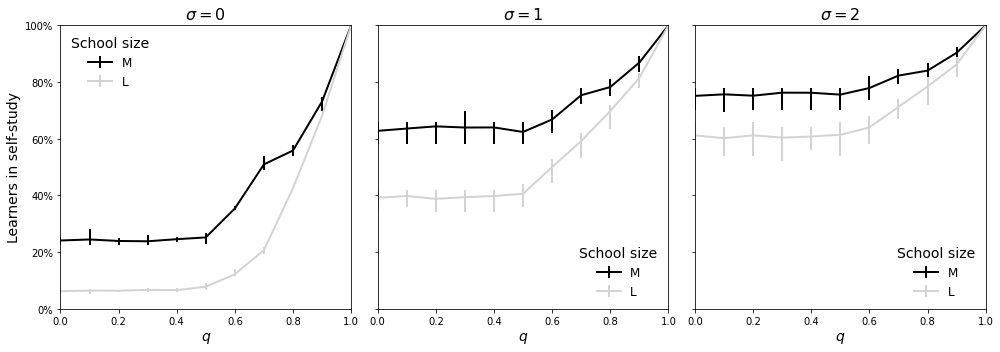

In [43]:
_, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
palette = {800: 'black', 1600: 'lightgrey'}

for ax, sig in zip(axes, [0, 1, 2]):
    for learners in [800, 1600]:
        res = (vq_df[(vq_df.progress == sig) & (vq_df.learners == learners)]["self-study (% learners)"]
                .groupby([vq_df.third_degree, vq_df.learners]).agg(["min", "mean", "max"]))

        errors = res[["min", "max"]].copy()
        errors["min"] = res["mean"] - res["min"]
        errors["max"] = res["max"] - res["mean"]

        res = res.reset_index()
        res.plot(ax=ax, x="third_degree", y="mean", yerr=errors.values.T, color=palette[learners])
    
    if ax is axes[0]:
        ax.legend(["M", "L"], title="School size", frameon=False, loc="upper left")
    else:
        ax.legend(["M", "L"], title="School size", frameon=False, loc="lower right")
        
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 100])
    ax.set_xlabel("$q$")
    ax.set_ylabel("Learners in self-study")
    ax.set_title(f"$\\sigma = {sig}$")

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

plt.tight_layout()
plt.savefig("out/varying_third_degree.pdf", bbox_inches='tight');